In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [4]:
print(X)

      year  tvtot  ppltrst  pplfair  pplhlp  happy  sclmeet  sclact  gndr  \
0        6    3.0      3.0     10.0     5.0    8.0      5.0     4.0   2.0   
1        6    6.0      5.0      7.0     5.0    9.0      3.0     2.0   2.0   
2        6    1.0      8.0      8.0     8.0    7.0      6.0     3.0   1.0   
3        6    4.0      6.0      6.0     7.0   10.0      6.0     2.0   2.0   
4        6    5.0      6.0      7.0     5.0    8.0      7.0     2.0   2.0   
6        6    3.0      0.0      5.0     2.0    0.0      2.0     2.0   1.0   
7        6    2.0      4.0      5.0     3.0   10.0      5.0     2.0   2.0   
8        6    2.0      8.0      8.0     8.0    9.0      6.0     4.0   2.0   
9        6    4.0      4.0      4.0     8.0    7.0      4.0     2.0   2.0   
10       6    1.0      6.0      7.0     7.0    9.0      5.0     2.0   2.0   
11       6    4.0      5.0      7.0     7.0    7.0      5.0     3.0   1.0   
12       6    4.0      7.0      7.0     4.0    9.0      6.0     2.0   1.0   

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [3]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

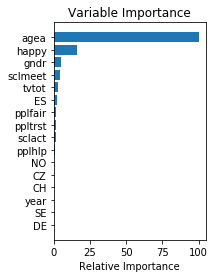

In [4]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

# Feature exploration

In [13]:
corrmatrix = df.corr()
print(corrmatrix['partner'].abs().sort_values(ascending=False).head(10))

partner                 1.000000
agea                    0.256670
sclmeet                 0.162970
agesocialinteraction    0.149124
happy                   0.145061
ppltrst                 0.034371
pplfair                 0.034054
gndr                    0.033984
tvtot                   0.028816
pplhlp                  0.022069
Name: partner, dtype: float64


partner    1.000000
agea       0.256670
sclmeet    0.162970
happy      0.145061
ppltrst    0.034371
pplfair    0.034054
gndr       0.033984
tvtot      0.028816
pplhlp     0.022069
year       0.018689
Name: partner, dtype: float64


In [22]:
df['agesocialinteraction']=df['agea']*df['sclmeet']

In [24]:
corrmatrix = df.corr()
print(corrmatrix['partner'].abs().sort_values(ascending=False).head(10))

partner                 1.000000
agea                    0.256670
sclmeet                 0.162970
agesocialinteraction    0.149124
happy                   0.145061
ppltrst                 0.034371
pplfair                 0.034054
gndr                    0.033984
tvtot                   0.028816
pplhlp                  0.022069
Name: partner, dtype: float64


In [47]:
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.6)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [31]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(n_estimators=)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.002182214948172395
Percent Type II errors: 0.02823240589198036

Test set accuracy:
Percent Type I errors: 0.11901840490797547
Percent Type II errors: 0.17791411042944785


#optimize for max depth

In [35]:
md= [2,3,4,5,6]
# Initialize and fit the model.
for m in md:
    clf = ensemble.GradientBoostingClassifier(n_estimators=500, max_depth=m, loss='deviance')
    clf.fit(X_train, y_train)

    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

# Accuracy tables.
    table_train = pd.crosstab(y_train, predict_train, margins=True)
    table_test = pd.crosstab(y_test, predict_test, margins=True)

    train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
    train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

    print((
    'maxdepth={}\n'
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    ).format(m, train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))
    

maxdepth=2
Training set accuracy:
Percent Type I errors: 0.044189852700491
Percent Type II errors: 0.1740316421167485
Test set accuracy:
Percent Type I errors: 0.05766871165644172
Percent Type II errors: 0.18773006134969325


maxdepth=3
Training set accuracy:
Percent Type I errors: 0.031642116748499725
Percent Type II errors: 0.14361702127659576
Test set accuracy:
Percent Type I errors: 0.08834355828220859
Percent Type II errors: 0.1754601226993865


maxdepth=4
Training set accuracy:
Percent Type I errors: 0.016639388979814512
Percent Type II errors: 0.10065466448445172
Test set accuracy:
Percent Type I errors: 0.09447852760736196
Percent Type II errors: 0.17423312883435582


maxdepth=5
Training set accuracy:
Percent Type I errors: 0.006001091107474086
Percent Type II errors: 0.04841789416257501
Test set accuracy:
Percent Type I errors: 0.11411042944785275
Percent Type II errors: 0.16809815950920245


maxdepth=6
Training set accuracy:
Percent Type I errors: 0.00027277686852154935
Perce

Looks like max depth = 4 is optimal. After that the model becomes overfit. Let's try to optimize for the number of estimators.

# Optimize for estimators

In [41]:
n_est= [400, 500, 600, 700, 800, 900]
# Initialize and fit the model.
for n in n_est:
    clf = ensemble.GradientBoostingClassifier(n_estimators=n, max_depth=4, loss='deviance')
    clf.fit(X_train, y_train)

    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

# Accuracy tables.
    table_train = pd.crosstab(y_train, predict_train, margins=True)
    table_test = pd.crosstab(y_test, predict_test, margins=True)

    train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
    train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

    print((
    'maxdepth={}\n'
    'estimators={}\n'
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    ).format(4, n, train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))
    

maxdepth=4
estimators=400
Training set accuracy:
Percent Type I errors: 0.020185488270594652
Percent Type II errors: 0.11361156573922532
Test set accuracy:
Percent Type I errors: 0.0834355828220859
Percent Type II errors: 0.1754601226993865


maxdepth=4
estimators=500
Training set accuracy:
Percent Type I errors: 0.016639388979814512
Percent Type II errors: 0.10065466448445172
Test set accuracy:
Percent Type I errors: 0.09325153374233129
Percent Type II errors: 0.17423312883435582


maxdepth=4
estimators=600
Training set accuracy:
Percent Type I errors: 0.013229678123295145
Percent Type II errors: 0.0894708128750682
Test set accuracy:
Percent Type I errors: 0.09079754601226994
Percent Type II errors: 0.18036809815950922


maxdepth=4
estimators=700
Training set accuracy:
Percent Type I errors: 0.012138570649208947
Percent Type II errors: 0.07733224222585924
Test set accuracy:
Percent Type I errors: 0.09938650306748466
Percent Type II errors: 0.18036809815950922


maxdepth=4
estimators=8

Estimators of 600 give an optimate result here - they substantially reduce type II errors at a cost of marginal overfitting...let's try changing the loss function:

# Optimizing for loss function

In [42]:
loss_list= ['deviance', 'exponential']
# Initialize and fit the model.
for l in loss_list:
    clf = ensemble.GradientBoostingClassifier(n_estimators=600, max_depth=4, loss=l)
    clf.fit(X_train, y_train)

    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

# Accuracy tables.
    table_train = pd.crosstab(y_train, predict_train, margins=True)
    table_test = pd.crosstab(y_test, predict_test, margins=True)

    train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
    train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

    print((
    'lossfunction={}\n'
    'maxdepth={}\n'
    'estimators={}\n'
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    ).format(l, 4, 600, train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))
    

lossfunction=deviance
maxdepth=4
estimators=600
Training set accuracy:
Percent Type I errors: 0.013229678123295145
Percent Type II errors: 0.0894708128750682
Test set accuracy:
Percent Type I errors: 0.09202453987730061
Percent Type II errors: 0.18036809815950922


lossfunction=exponential
maxdepth=4
estimators=600
Training set accuracy:
Percent Type I errors: 0.01568466993998909
Percent Type II errors: 0.1039279869067103
Test set accuracy:
Percent Type I errors: 0.09570552147239264
Percent Type II errors: 0.1754601226993865




Ok, so we've optimized our model. let's do some cross validation here...
I think our high type ii errors on the test set may be a product of low sample size.

In [48]:
clf = ensemble.GradientBoostingClassifier(n_estimators=600, max_depth=4, loss=l)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
'lossfunction={}\n'
'maxdepth={}\n'
'estimators={}\n'
'Training set accuracy:\n'
'Percent Type I errors: {}\n'
'Percent Type II errors: {}\n'
'Test set accuracy:\n'
'Percent Type I errors: {}\n'
'Percent Type II errors: {}\n\n'
).format(l, 4, 600, train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))
    

lossfunction=exponential
maxdepth=4
estimators=600
Training set accuracy:
Percent Type I errors: 0.008183306055646482
Percent Type II errors: 0.07405891980360066
Test set accuracy:
Percent Type I errors: 0.08254065664314207
Percent Type II errors: 0.18502608162012887




In [49]:
clf.score(X_test, y_test)

0.7324332617367291

In [44]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, X, y, cv=5)

array([0.7607362 , 0.69815951, 0.7398773 , 0.73050952, 0.69164619])

# Discussion:

Here is a summary of the changes that we've made :

Training set accuracy:
Percent Type I errors: 0.04650845608292417 ----> 0.008
Percent Type II errors: 0.17607746863066012 ----> 0.074

Test set accuracy:
Percent Type I errors: 0.06257668711656442  ---> 0.08
Percent Type II errors: 0.18527607361963191 ---> 0.185

Our model looks slightly more overfit, but it predicts the whole dataset with greater accuracy.